참고논문
1. Squeeze-and-Excitation Networks
2. Competitive Inner-Imaging Squeeze and Excitation for Residual Network

In [1]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# Train data preprocessing (with augmentation + scaling)
transforms_cifar10_train = transforms.Compose([
    transforms.Resize((36, 36)),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Test data preprocessing (with scaling only)
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
#배치 사이즈 바꿔도 됨, 셔플은 학습순서 기억하지 못하도록 하기 위해 사용.

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
#배치 사이즈 바꿔도 됨, test는 셔플 필요없음 .

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]


horse  deer  frog  ship


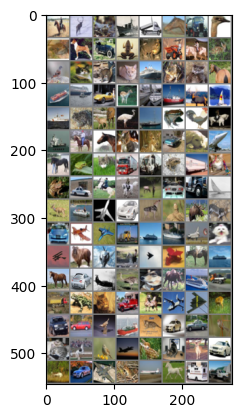

In [4]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
# CMPE-SE 블록 정의
class CMPE_SE_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CMPE_SE_Block, self).__init__()
        self.reduction = reduction
        mid = channel // reduction

        # 3x3 conv로 inner-imaging (pair-view) attention
        self.conv = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(channel, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, identity):
        b, c, _, _ = x.size()

        # Global Average Pooling
        x_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
        id_pool = F.adaptive_avg_pool2d(identity, 1).view(b, c)

        # reshape for 2D conv inner-imaging
        pair = torch.stack([x_pool, id_pool], dim=1).unsqueeze(-1)  # [B, 2, C, 1]
        attn = self.conv(pair).squeeze(-1).squeeze(1)  # [B, C]

        # Excitation
        scale = self.fc(attn).view(b, c, 1, 1)
        return x * scale.expand_as(x)

# PreAct BasicBlock + CMPE-SE
class PreActBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

        self.se = CMPE_SE_Block(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        identity = x
        shortcut = self.shortcut(out) if isinstance(self.shortcut, nn.Conv2d) else self.shortcut(x)

        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))

        # CMPE-SE
        out = self.se(out, shortcut)
        out += shortcut
        return out

# 전체 ResNet 구조
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, out_planes, s))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        return self.linear(out)

# 모델 생성
def ResNet56_CMPESE():
    return ResNet(PreActBlock, [9, 9, 9])

# 모델 정의
net =  ResNet56_CMPESE().to(device)

In [9]:
#SGD + Momentum + StepLR 조합으로 수정(Adam + CosineAnnealingLR 조합보다 정확도 높음, 단 추가 실험 필요)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 정확도 계산 함수
def compute_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [ ]:
# Train the model
epochs = 200

for epoch in range(epochs):

    loss_tmp = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

[Epoch - 1] Loss: 1.670
[Epoch - 2] Loss: 1.438
[Epoch - 3] Loss: 1.284
[Epoch - 4] Loss: 1.166
[Epoch - 5] Loss: 1.067
[Epoch - 6] Loss: 0.983
[Epoch - 7] Loss: 0.914
[Epoch - 8] Loss: 0.852
[Epoch - 9] Loss: 0.797
[Epoch - 10] Loss: 0.706
[Epoch - 11] Loss: 0.673
[Epoch - 12] Loss: 0.639
[Epoch - 13] Loss: 0.607
[Epoch - 14] Loss: 0.577
[Epoch - 15] Loss: 0.545
[Epoch - 16] Loss: 0.516
[Epoch - 17] Loss: 0.487
[Epoch - 18] Loss: 0.454
[Epoch - 19] Loss: 0.423
[Epoch - 20] Loss: 0.333
[Epoch - 21] Loss: 0.294
[Epoch - 22] Loss: 0.278
[Epoch - 23] Loss: 0.250
[Epoch - 24] Loss: 0.236
[Epoch - 25] Loss: 0.218
[Epoch - 26] Loss: 0.199
[Epoch - 27] Loss: 0.190
[Epoch - 28] Loss: 0.164
[Epoch - 29] Loss: 0.161
[Epoch - 30] Loss: 0.119
[Epoch - 31] Loss: 0.099
[Epoch - 32] Loss: 0.094
[Epoch - 33] Loss: 0.087
[Epoch - 34] Loss: 0.084
[Epoch - 35] Loss: 0.076
[Epoch - 36] Loss: 0.073
[Epoch - 37] Loss: 0.069
[Epoch - 38] Loss: 0.064
[Epoch - 39] Loss: 0.061
[Epoch - 40] Loss: 0.053
[Epoch - 

GroundTruth:    cat  ship  ship plane
Predicted:   frog plane  ship   car


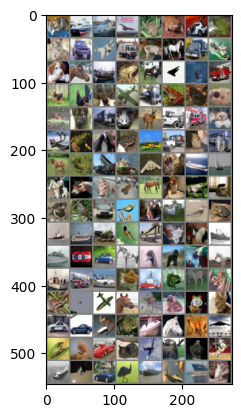

In [11]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [12]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10,000 test images: 33 %
